In [ ]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!pip install opencv-python ipywidgets imageio

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from Seq2Seq import Seq2Seq
from torch.utils.data import DataLoader
import os
import cv2
import time
from tqdm import tqdm
import wandb

#os.environ["TORCH_DEVICE"] = "cuda"
torch.cuda.is_available()

False

# Data Preparation

In [2]:
from pathlib import Path
from datetime import datetime
import numpy as np
p = Path('C:\Users\o.abdulmalik\Documents\Shadow-Mitigation')
#device = os.environ.get("TORCH_DEVICE", 'cuda')

In [3]:

dataset = {}
for path in Path(p, 'SKIPPD').rglob('*.jpg'):
    x = path.stem

    year, month, day, hour, minute = x[:4], x[4:6], x[6:8],x[8:10],x[10:12]
    
    key = f'{year}-{month}-{day}-{hour}'
    if key not in dataset.keys():
        dataset[key] = []
    
    dataset[key].append(path)
    
for key, value in dataset.items():
    dataset[key] = sorted(value)
   

In [4]:
faulty = []
correct = []
for k, v in dataset.items():
    if len(v) != 60:
        
        faulty.append(k)
    else:
        correct.append(k)

In [5]:

SKIPPD = []
for valid in correct:
    #print(valid)
    SKIPPD.append([cv2.imread(str(i), cv2.IMREAD_GRAYSCALE) for i in dataset[valid]])
print(np.array(SKIPPD).shape)

(1251, 60, 64, 64)


In [6]:
# Assuming SKIPPD is a numpy array with shape (1251, 60, 64, 64)
threshold = 20000*255  # Example threshold value

# Calculate the sum of pixel values for each sequence
sequence_sums = np.sum(SKIPPD, axis=(1, 2, 3))

# Filter sequences where the sum is above the threshold
filtered_indices = np.where(sequence_sums > threshold)[0]
filtered_SKIPPD = np.array(SKIPPD)[filtered_indices]

print(f"Original shape: {np.array(SKIPPD).shape}")
print(f"Filtered shape: {filtered_SKIPPD.shape}")

Original shape: (1251, 60, 64, 64)
Filtered shape: (490, 60, 64, 64)


In [7]:
from torch.utils.data import DataLoader


SKIPPD_SHORT = filtered_SKIPPD[:int(len(filtered_SKIPPD))]
# Shuffle Data
np.random.shuffle(SKIPPD_SHORT)


# Train, Test, Validation splits
train_data = SKIPPD_SHORT[:int(0.7*len(SKIPPD_SHORT))]       
val_data = SKIPPD_SHORT[int(0.7*len(SKIPPD_SHORT)):int(0.9*len(SKIPPD_SHORT))]       
test_data = SKIPPD_SHORT[int(0.9*len(SKIPPD_SHORT)):]     

def collate(batch, device='cuda', threshold=1000, max_attempts=15):
    # Convert batch to tensor, add channel dimension, and scale
    batch = torch.tensor(batch).unsqueeze(1) / 255.0
    batch = batch.to(device)

    for _ in range(max_attempts):
        # Randomly pick a sequence
        rand = np.random.randint(15, 59)
        input_seq = batch[:, :, rand-15:rand]
        target = batch[:, :, rand+1]
       
        # Check if the sum of the sequence exceeds the threshold
        if input_seq.sum() > threshold:

            return input_seq, target

    return input_seq, target

# Example usage (adjust as per your actual 'device' and 'batch' data)


# # Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=16, collate_fn=collate,num_workers=1)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, 
                        batch_size=16, collate_fn=collate,num_workers=1)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

for hour in faulty:
    images =[cv2.imread(str(i), cv2.IMREAD_GRAYSCALE) for i in dataset[hour]]

    for image in images:
        print(image.shape)
    # fig, axs = plt.subplots(8, 8, figsize=(12, 12))

    # for i, ax in enumerate(axs.flat):
    #     if i < len(images):
    #         ax.imshow(images[i], cmap='gray')
    #     ax.axis('off')

    # plt.tight_layout()
    # plt.show()

In [ ]:
import io
import imageio
from ipywidgets import widgets, HBox

# Get a batch
input, _ = next(iter(val_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0     

for video in input.squeeze(1)[:32]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))

C:\Users\Omar\AppData\Local\Temp\ipykernel_15520\4193949264.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  batch = torch.tensor(batch).unsqueeze(1) / 255.0


Input sequence shape: (16, 1, 15, 64, 64)
Target shape: (16, 1, 64, 64)


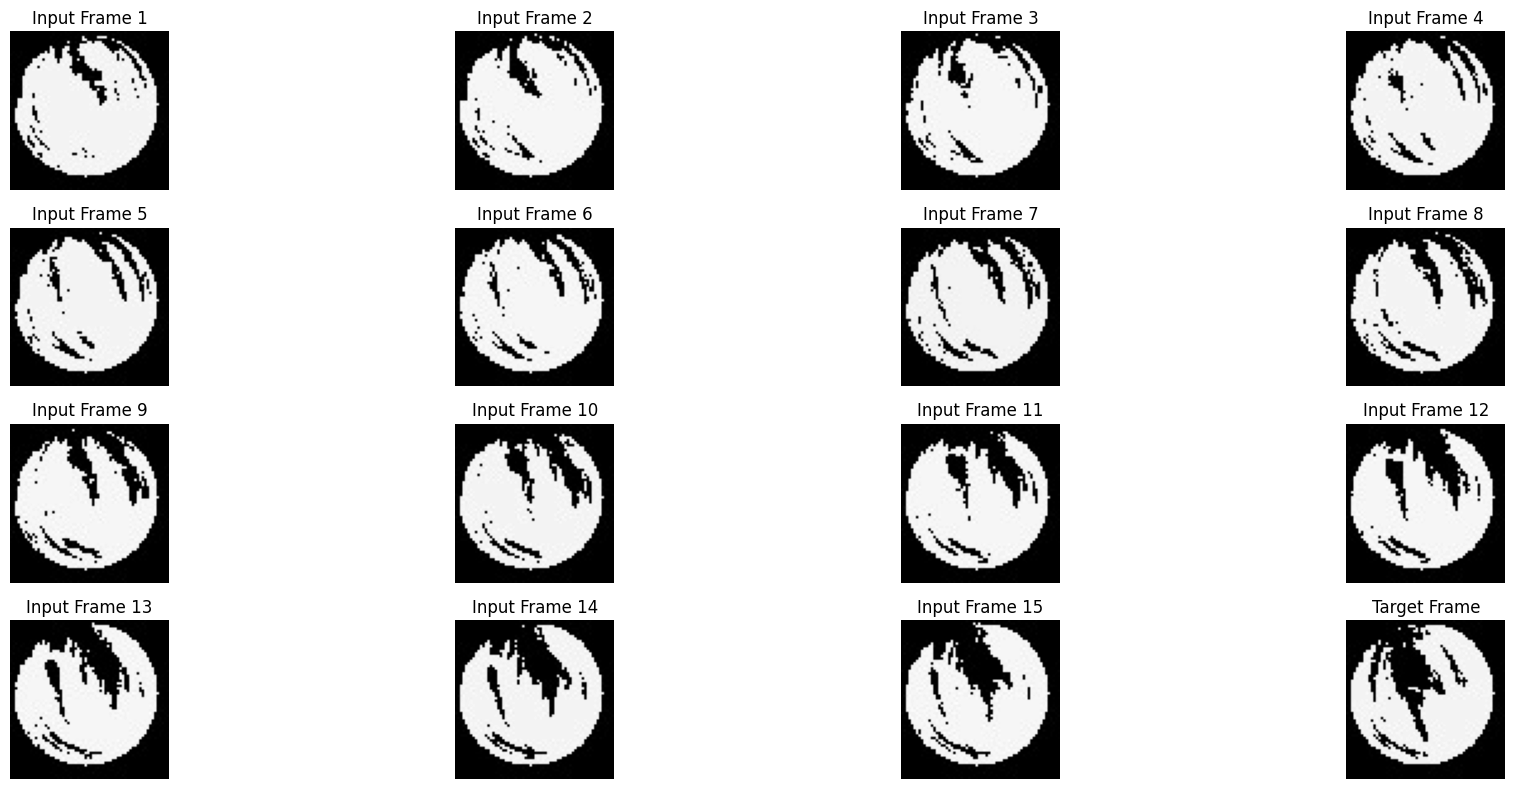

In [8]:
import matplotlib.pyplot as plt

# Get a batch
for input_seq, target in val_loader:
    # Reverse process before displaying
    input_seq = input_seq.cpu().numpy() * 255.0
    target = target.cpu().numpy() * 255.0
    
    print("Input sequence shape:", input_seq.shape)
    print("Target shape:", target.shape)
    
     #Adjust the figure size as needed
    plt.figure(figsize=(20, 8))

    # Displaying the input sequence frames
    for i in range(input_seq.shape[2]):  # input_seq.shape[2] should be 15 for the sequence length
        plt.subplot(4, 4, i+1)  # Adjust the grid to 4x4 to fit all 16 images
        plt.imshow(input_seq[0, 0, i], cmap='gray')
        plt.title(f'Input Frame {i+1}')
        plt.axis('off')

    # Displaying the target frame
    plt.subplot(4, 4, 16)  # Position for the target frame in the 4x4 grid
    plt.imshow(target[0,0], cmap='gray')
    plt.title('Target Frame')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    break  # Only process the first batch for demonstration


# Model & Training

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = 'cuda'
# The input video frames are grayscale, thus single channel
model = Seq2Seq(num_channels=1, num_kernels=64, 
kernel_size=(3, 3), padding=(1, 1), activation="relu", 
frame_size=(64, 64), num_layers=3).to(device)
lr=1e-4
optim = Adam(model.parameters(), lr=lr)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction='sum')
min_loss = float('inf')
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=5)


In [13]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ShadowMitigation",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-7,
    "architecture": "CONVLSTM - 3 Layers",
    "dataset": "0.3 SKIPPD",
    "epochs": 100,
    }
)

loss,█▆▅▂▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁
val_loss_perc,█▆▅▂▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁
loss,1240.23956
val_loss_perc,30.27929


In [ ]:
asd = torch.load(r'C:\Users\Omar\Documents\ShadowMitigation\playground\pyt\best.pth')
model.load_state_dict(asd['model_state_dict'])

In [11]:
num_epochs = 50




for epoch in range(1, num_epochs+1):

            

        
    start = time.time()
    train_loss = 0                                                 
    model.train()                                                  
    for batch_num, (input_seq, target) in enumerate(tqdm(train_loader), 1):  
        batch_start = time.time()
        output = model(input_seq)          
                                   
        loss = criterion(output.flatten(), target.flatten())       
                           
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()  
                       

        # train_loss += loss.item()


    train_loss /= len(train_loader.dataset)                       
    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:                          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()                                
    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)

    if val_loss < min_loss:
        if val_loss < min_loss or min_loss == 0:                        
            ts = str(time.time()).split(".")[0]
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                }
            torch.save(checkpoint, f'best_240220_2.pth')
            min_loss = val_loss
            
    wandb.log({"loss": val_loss,"val_loss_perc":val_loss/(64*64) *100})
    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n  Validation Loss percentage: {:.2f}    Time: {:.2f}".format(
       epoch, train_loss, val_loss, val_loss/(64*64) *100,time.time()-start))


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:1 Training Loss:0.00 Validation Loss:2397.82
  Validation Loss percentage: 58.54    Time: 17.69


100%|██████████| 22/22 [00:11<00:00,  1.87it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:2 Training Loss:0.00 Validation Loss:2076.83
  Validation Loss percentage: 50.70    Time: 14.50


100%|██████████| 22/22 [00:11<00:00,  1.87it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:3 Training Loss:0.00 Validation Loss:1853.86
  Validation Loss percentage: 45.26    Time: 14.54


100%|██████████| 22/22 [00:11<00:00,  1.88it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:4 Training Loss:0.00 Validation Loss:1422.67
  Validation Loss percentage: 34.73    Time: 14.59


100%|██████████| 22/22 [00:11<00:00,  1.87it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:5 Training Loss:0.00 Validation Loss:1307.71
  Validation Loss percentage: 31.93    Time: 14.67


100%|██████████| 22/22 [00:12<00:00,  1.80it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:6 Training Loss:0.00 Validation Loss:1379.74
  Validation Loss percentage: 33.69    Time: 15.03


100%|██████████| 22/22 [00:11<00:00,  1.87it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:7 Training Loss:0.00 Validation Loss:1335.39
  Validation Loss percentage: 32.60    Time: 14.58


100%|██████████| 22/22 [00:11<00:00,  1.88it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:8 Training Loss:0.00 Validation Loss:1245.85
  Validation Loss percentage: 30.42    Time: 14.57


100%|██████████| 22/22 [00:12<00:00,  1.79it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:9 Training Loss:0.00 Validation Loss:1290.38
  Validation Loss percentage: 31.50    Time: 15.10


100%|██████████| 22/22 [00:11<00:00,  1.87it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:10 Training Loss:0.00 Validation Loss:1333.31
  Validation Loss percentage: 32.55    Time: 14.64


100%|██████████| 22/22 [00:11<00:00,  1.86it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:11 Training Loss:0.00 Validation Loss:1248.22
  Validation Loss percentage: 30.47    Time: 14.68


100%|██████████| 22/22 [00:11<00:00,  1.88it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:12 Training Loss:0.00 Validation Loss:1239.61
  Validation Loss percentage: 30.26    Time: 14.68


100%|██████████| 22/22 [00:11<00:00,  1.87it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:13 Training Loss:0.00 Validation Loss:1250.51
  Validation Loss percentage: 30.53    Time: 14.64


100%|██████████| 22/22 [00:11<00:00,  1.88it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:14 Training Loss:0.00 Validation Loss:1291.73
  Validation Loss percentage: 31.54    Time: 14.62


100%|██████████| 22/22 [00:11<00:00,  1.85it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:15 Training Loss:0.00 Validation Loss:1332.59
  Validation Loss percentage: 32.53    Time: 14.89


100%|██████████| 22/22 [00:11<00:00,  1.84it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:16 Training Loss:0.00 Validation Loss:1242.75
  Validation Loss percentage: 30.34    Time: 14.78


100%|██████████| 22/22 [00:11<00:00,  1.86it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:17 Training Loss:0.00 Validation Loss:1228.42
  Validation Loss percentage: 29.99    Time: 14.97


100%|██████████| 22/22 [00:12<00:00,  1.83it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:18 Training Loss:0.00 Validation Loss:1260.99
  Validation Loss percentage: 30.79    Time: 14.98


100%|██████████| 22/22 [00:11<00:00,  1.86it/s]


torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 15, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([2, 1, 15, 64, 64]) torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
Epoch:19 Training Loss:0.00 Validation Loss:1240.24
  Validation Loss percentage: 30.28    Time: 14.73


 14%|█▎        | 3/22 [00:02<00:12,  1.49it/s]


KeyboardInterrupt: 

In [ ]:
def collate_test(batch):

    # Last 15 frames are target
    target = np.array(batch)[:,45:]                     
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

# Test Data Loader

test_loader = DataLoader(test_data,shuffle=True, 
                         batch_size=20, collate_fn=collate_test)

# Get a batch
batch, target = next(iter(test_loader))

# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)

# Loop over timesteps
for timestep in tqdm(range(target.shape[1])):
  input = batch[:,:,timestep:timestep+15]   
  output[:,timestep]=(model(input).squeeze(1).cpu()>0.5)*255.0

In [ ]:
from random import shuffle
shuffle(list(zip(target, output)))

for tgt, out in zip(target, output):       # Loop over samples
    
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = 2)    
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = 2)    
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif), 
                  widgets.Image(value=output_gif)]))